In [8]:
import numpy as np
import cv2
import glob
import time
import pickle
import os
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from helper_functions import *
%matplotlib inline

In [6]:
#Working Directory
os.chdir("/Users/pratham/Downloads")

In [5]:
# Read non-vehicles and vehicles images
notcars = glob.glob('non-vehicles/*/*.png')
cars = glob.glob('vehicles/*/*.png')



# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

(<matplotlib.axes._subplots.AxesSubplot at 0x11b704550>,
 <matplotlib.text.Text at 0x11b864ad0>)

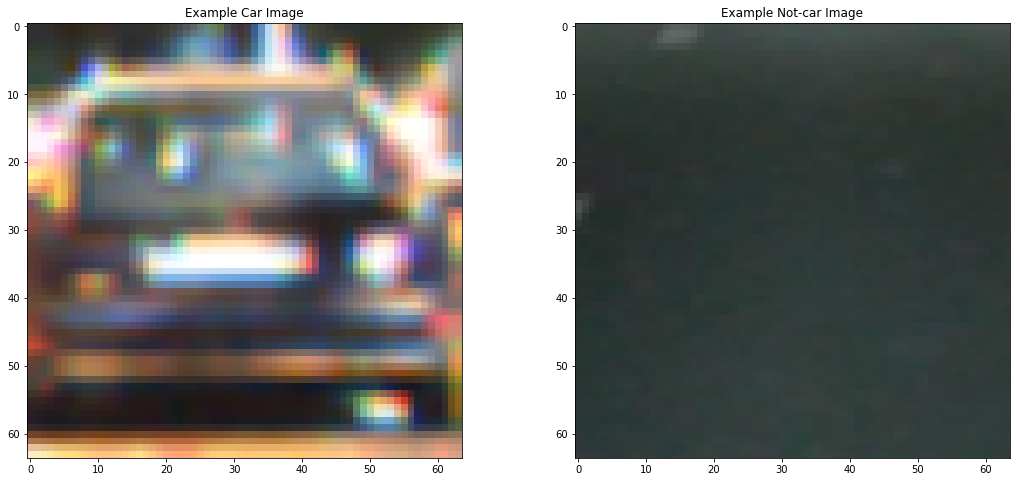

In [6]:
# Plot the examples
fig = plt.figure(figsize=(18,8))
plt.subplot(121), plt.imshow(car_image), plt.title('Example Car Image')
plt.subplot(122), plt.imshow(notcar_image), plt.title('Example Not-car Image')

In [10]:
from skimage.feature import hog

In [12]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

<h1><strong>Histogram of Oriented Gradient(HOG)</strong></h1>

In [13]:
# Read in the image
car_YCrCb = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)
notcar_YCrCb = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2YCrCb)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
features = []
hog_images = []
# Call our function with vis=True to see an image output
for i in range(car_YCrCb.shape[2]):
    _, hog_image = get_hog_features(car_YCrCb[:,:,i], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
    hog_images.append(hog_image)
    _, hog_image = get_hog_features(notcar_YCrCb[:,:,i], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
    hog_images.append(hog_image)

/Users/pratham/anaconda2/lib/python2.7/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


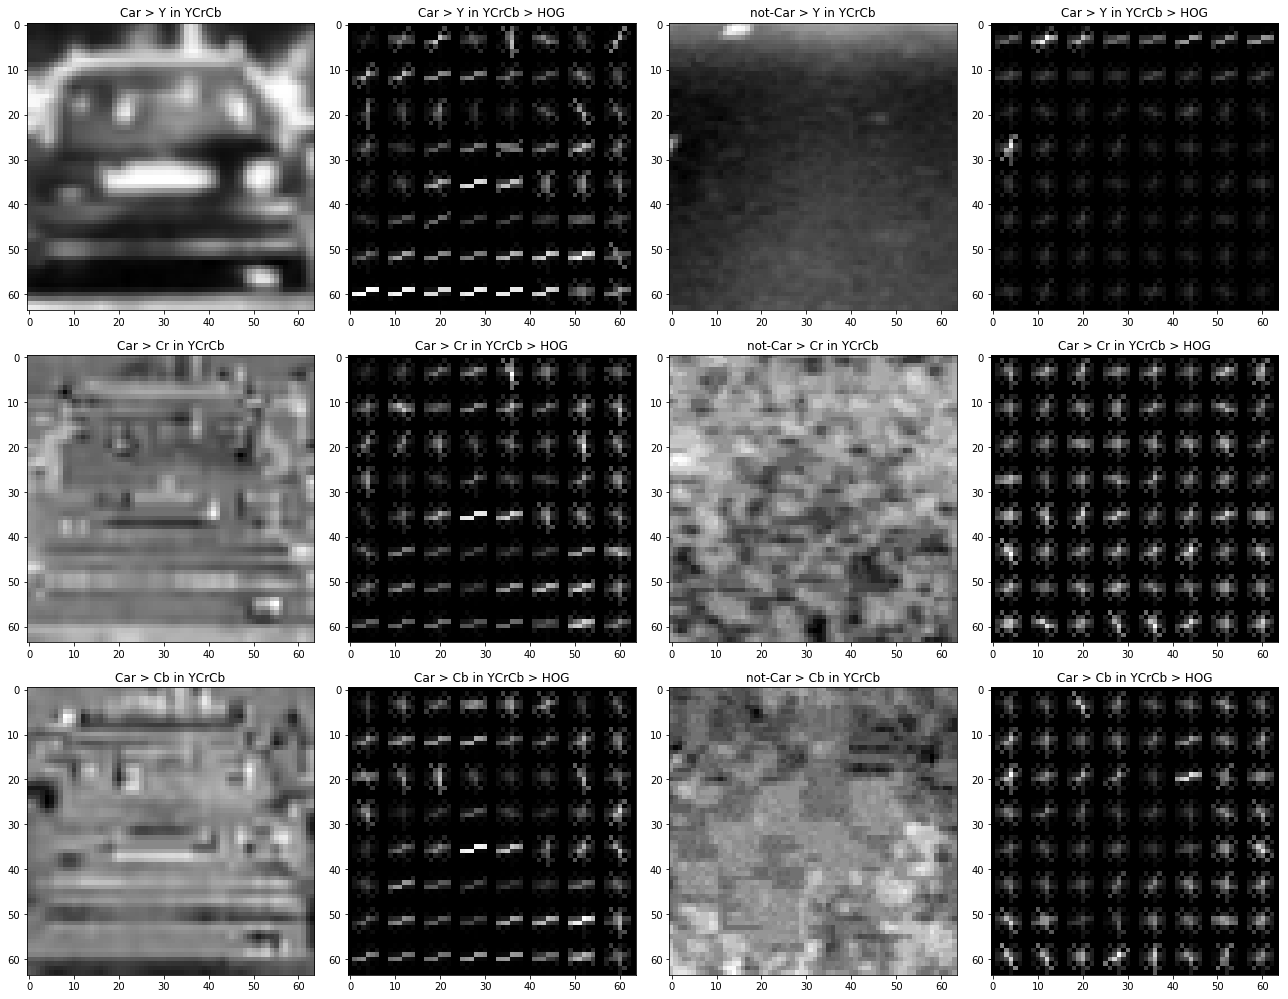

In [14]:
# Plot the examples
fig = plt.figure(figsize=(18,14))
plt.subplot(341), plt.imshow(car_YCrCb[:,:,0], cmap='gray'), plt.title('Car > Y in YCrCb')
plt.subplot(342), plt.imshow(hog_images[0], cmap='gray'), plt.title('Car > Y in YCrCb > HOG')
plt.subplot(343), plt.imshow(notcar_YCrCb[:,:,0], cmap='gray'), plt.title('not-Car > Y in YCrCb')
plt.subplot(344), plt.imshow(hog_images[1], cmap='gray'), plt.title('Car > Y in YCrCb > HOG')
plt.subplot(345), plt.imshow(car_YCrCb[:,:,1], cmap='gray'), plt.title('Car > Cr in YCrCb')
plt.subplot(346), plt.imshow(hog_images[2], cmap='gray'), plt.title('Car > Cr in YCrCb > HOG')
plt.subplot(347), plt.imshow(notcar_YCrCb[:,:,1], cmap='gray'), plt.title('not-Car > Cr in YCrCb')
plt.subplot(348), plt.imshow(hog_images[3], cmap='gray'), plt.title('Car > Cr in YCrCb > HOG')
plt.subplot(349), plt.imshow(car_YCrCb[:,:,2], cmap='gray'), plt.title('Car > Cb in YCrCb')
plt.subplot(3,4,10), plt.imshow(hog_images[4], cmap='gray'), plt.title('Car > Cb in YCrCb > HOG')
plt.subplot(3,4,11), plt.imshow(notcar_YCrCb[:,:,2], cmap='gray'), plt.title('not-Car > Cb in YCrCb')
plt.subplot(3,4,12), plt.imshow(hog_images[5], cmap='gray'), plt.title('Car > Cb in YCrCb > HOG')
fig.tight_layout()

In [16]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


In [36]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [39]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

<h1>Feature Extraction</h1>

In [21]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

In [22]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

('Using:', 9, 'orientations', 8, 'pixels per cell and', 2, 'cells per block')
('Feature vector length:', 6156)


<h1><strong>SVM Classification</strong></h1>

In [23]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Save svc and parameters to a pickle file
try:
    f = open('svc.p', 'wb')
    save = {
      'svc': svc,
      'scaler': X_scaler,
      'orient': orient,
      'pix_per_cell': pix_per_cell,
      'cell_per_block': cell_per_block,
      'spatial_size': spatial_size,
      'hist_bins': hist_bins
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', 'svc.p', ':', e)
    raise
    
statinfo = os.stat('svc.p')
print('Compressed pickle size:', statinfo.st_size)

(27.71, 'Seconds to train SVC...')
('Test Accuracy of SVC = ', 0.987)
('Compressed pickle size:', 198033)


(<matplotlib.axes._subplots.AxesSubplot at 0x11ea80e50>,
 <matplotlib.text.Text at 0x11df8f710>)

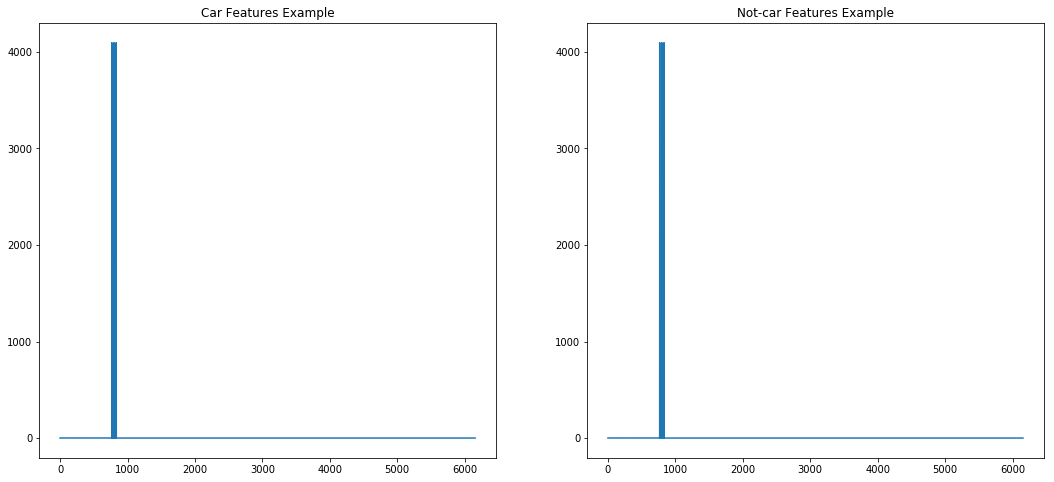

In [24]:
# Plot samples of features
fig = plt.figure(figsize=(18,8))
plt.subplot(121), plt.plot(car_features[car_ind]), plt.title('Car Features Example')
plt.subplot(122), plt.plot(notcar_features[notcar_ind]), plt.title('Not-car Features Example')

<h1><strong>HOG sub-sampling</strong></h1>

In [9]:
# Load data from the pickle file
with open('svc.p', 'rb') as f:
    dist_pickle = pickle.load(f)
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    del dist_pickle

im_list = glob.glob('test_images/*.jpg')

ystart = 400
ystop = 656
scale = 1.5

In [10]:

for img_name in im_list:
    img = mpimg.imread(img_name)
    out_img, box_list = find_cars(img, ystart, ystop, scale, 
                              svc, X_scaler, orient, pix_per_cell, 
                              cell_per_block, spatial_size, hist_bins)

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img, _ = draw_labeled_bboxes(np.copy(img), labels)
    
    fig = plt.figure(figsize=(18,8))
    plt.subplot(131), plt.imshow(out_img), plt.title('HOG Windows')
    plt.subplot(132), plt.imshow(heatmap, cmap='hot'), plt.title('Heat Map')
    plt.subplot(133), plt.imshow(draw_img), plt.title('Car Positions')
    fig.tight_layout()

In [11]:
from collections import deque
import numpy as np
from scipy.ndimage.measurements import label
from helper_functions import *

# Define a class to receive the characteristics of each line detection
class Vehicles():
    def __init__(self):
        self.current_bboxes = []
        self.recent_bboxes = deque([], 12)
        self.img = None
        self.draw_img = None
        self.frame = 0
        self.new_ystop = 0

    def draw_over_frames(self, box_list):
        self.recent_bboxes.append(box_list)
        heat = np.zeros_like(self.img[:,:,0]).astype(np.float)
        for bbox_list in self.recent_bboxes:
            heat = add_heat(heat, bbox_list)
        heat = apply_threshold(heat, len(self.recent_bboxes)/3)
        heatmap = np.clip(heat, 0, 255)
        labels = label(heatmap)
        self.draw_img, car_box = draw_labeled_bboxes(np.copy(self.img), labels)
        if np.array(car_box).any():
            self.current_bboxes = car_box
            self.new_ystop = np.amax(np.array(car_box), axis=0)[1,1] + 64
        else:
            self.new_ystop = 0
        return  self.draw_img

<h1><strong>Video Processing</strong></h1>

In [42]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
from helper_functions import *
from scipy.ndimage.measurements import label

with open('svc.p', 'rb') as f:
    dist_pickle = pickle.load(f)
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    del dist_pickle

ystarts = [400, 400, 400, 400]
ystops = [496, 528, 592, 656]
scales = [1., 1.25, 1.5, 1.75]

def process_image(img):
    return pipeline(img, cars, ystarts, ystops, scales,
                    svc, X_scaler, orient, pix_per_cell,
                    cell_per_block, spatial_size, hist_bins)

In [1]:
cars = Vehicles()
video_output = 'test_output.mp4'
clip1 = VideoFileClip('test_video.mp4')
video_clip = clip1.fl_image(process_image)
%time video_clip.write_videofile(video_output, audio=False)